In [49]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

import torch
from torch import nn
from torchsummary import summary
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import textwrap
from tqdm import tqdm
from pprint import pprint

In [4]:
df = pd.read_csv("rJokesData/data/preprocessed.csv")
df.sample(5)

,joke,body,punchline,score,date
198942,What's Trump's favorite Olympic sport? Fencing!,Fencing!,What's Trump's favorite Olympic sport?,7.0,1.472245e+09
289297,A chicken and egg are lying in bed. The chicke...,"The egg says to herself, ""I guess we answered ...",A chicken and egg are lying in bed. The chicke...,58.0,1.496402e+09
381020,A poor African man is walking across the deser...,"He's lost, thirsty and completely hopeless. At...",A poor African man is walking across the desert,8.0,1.525686e+09
440631,What's brown and rhymes with snoop? Dr Dre,Dr Dre,What's brown and rhymes with snoop?,108.0,1.543570e+09
62652,Did you hear about the cannibal walking throug...,he passed his brother?,Did you hear about the cannibal walking throug...,0.0,1.417380e+09


In [5]:
df = df.dropna(axis=0)
df.head()

,joke,body,punchline,score,date
178,I hope you're all getting your Walter Cronkite...,"Here's mine. \n\nEd McMahon, David Carradine, ...",I hope you're all getting your Walter Cronkite...,8.0,1.246240e+09
182,What is the only thing a woman can say that wi...,"""Your dick is bigger than your brother's.""",What is the only thing a woman can say that wi...,24.0,1.247151e+09
184,What do scientists use to measure a chicken's ...,An egg timer,What do scientists use to measure a chicken's ...,0.0,1.247210e+09
189,Two Gay guys are lying on their bed... Two gay...,Two gay guys are lying on their bed. The firs...,Two Gay guys are lying on their bed...,0.0,1.247510e+09
193,At 12:01 after midnight... At 12:01 after midn...,"At 12:01 after midnight, on a cloudy evening, ...",At 12:01 after midnight...,0.0,1.248463e+09


In [6]:
n_context = 10

In [7]:
text = (" # " * n_context).join(list(df.loc[:, "joke"]))
print(len(text))
print(textwrap.fill(text[:300], 80))

154828313
I hope you're all getting your Walter Cronkite jokes in order. He's next.
Here's mine.   Ed McMahon, David Carradine, Farrah Fawcett, Michael Jackson,
Billy Mays, and Walter Cronkite walk into a bar.   And die.   Your turn.  #  #
#  #  #  #  #  #  #  # What is the only thing a woman can say that w


In [8]:
tokenizer = RegexpTokenizer(r'\w+|#')
tokens = tokenizer.tokenize(text.lower())
print(tokens[20:50])
print(len(tokens))

tokens = tokens[:10000] #NOTE: for test purposes

['david', 'carradine', 'farrah', 'fawcett', 'michael', 'jackson', 'billy', 'mays', 'and', 'walter', 'cronkite', 'walk', 'into', 'a', 'bar', 'and', 'die', 'your', 'turn', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', 'what']
32106460


In [9]:
unique_tokens = set(tokens)
tokens_dict = {word: i for i, word in enumerate(unique_tokens)}

In [10]:
input_words = []
next_words = []
for i in tqdm(range(len(tokens) - n_context)):
    input_words.append(tokens[i:i+n_context])
    next_words.append(tokens[i+n_context])

100%|██████████| 9990/9990 [00:00<00:00, 1360513.57it/s]


In [11]:
pprint(input_words[25:30])
pprint(next_words[25:30])

[['jackson',
  'billy',
  'mays',
  'and',
  'walter',
  'cronkite',
  'walk',
  'into',
  'a',
  'bar'],
 ['billy',
  'mays',
  'and',
  'walter',
  'cronkite',
  'walk',
  'into',
  'a',
  'bar',
  'and'],
 ['mays',
  'and',
  'walter',
  'cronkite',
  'walk',
  'into',
  'a',
  'bar',
  'and',
  'die'],
 ['and',
  'walter',
  'cronkite',
  'walk',
  'into',
  'a',
  'bar',
  'and',
  'die',
  'your'],
 ['walter',
  'cronkite',
  'walk',
  'into',
  'a',
  'bar',
  'and',
  'die',
  'your',
  'turn']]
['and', 'die', 'your', 'turn', '#']


In [112]:
X = np.zeros(shape=(len(input_words), n_context, len(tokens_dict)), dtype=bool)
y = np.zeros(shape=(len(input_words), len(tokens_dict)), dtype=bool)

for i, words in enumerate(tqdm(input_words)):
    for j, word in enumerate(words):
        X[i, j, tokens_dict[words[j]]] = 1
    y[i, tokens_dict[next_words[i]]] = 1

100%|██████████| 9990/9990 [00:00<00:00, 166900.07it/s]


In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]
    

model = nn.Sequential(
    nn.LSTM(input_size=len(unique_tokens), hidden_size=128, num_layers=2, batch_first=True),
    extract_tensor(),
    nn.Linear(in_features=128, out_features=len(unique_tokens)),
    nn.Softmax(dim=1)
).to(device)

In [114]:
def run(model, dataloader, loss_function, optimizer=None):
    # set the model to evaluation or training mode
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0

    for X, y in dataloader:
        # compute prediction
        pred = model(X)
        # compute loss
        loss = loss_function(pred, y)
        # save loss
        total_loss += loss.item()
        if optimizer != None:
            # compute gradients
            loss.backward()
            # do optimizer step
            optimizer.step()
            # clear gradients
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [115]:
from IPython.display import clear_output

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

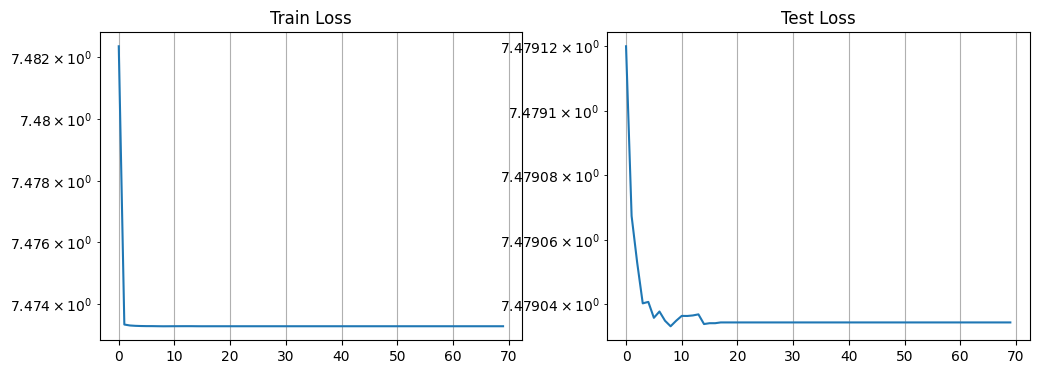

KeyboardInterrupt: 

In [117]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

data = list(zip(X.astype('float32'), y.astype('float32')))
train_dataset, valid_dataset = train_test_split(data, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 10 == 9:
        show_losses(train_loss_hist, test_loss_hist)